# Introdução

## Problema

O Head de Crédito de uma fintech, que hoje toma suas decisões de concessão através do setor de BI, observou crescimento expressivo na carteira de clientes, porém a taxa de inadimplência do mercado também apresenta crescimento.


Com este cenário em mente, criou-se uma necessidade de revisar as políticas de crédito da empresa, bem como forma a forma como o crédito é concedido.

## Solução

Desenvolver um modelo de crédito que seja capaz de gerar um score de risco para contratação de produtos de crédito, utilizando as várias fontes de dados em mãos (imagem abaixo), como registros de transações bancárias, histórico de pagamentos e informações socioeconomicas.</div>



É fundamental que o modelo consiga ordenação das faixas de score, apresente estabilidade temporal e tenha <b>interpretabilidade</b> para que a área de negócio consiga tomar as decisões.


Esta solução ajuda na avaliação do risco de concessão, e também apoia a criação de uma política de crédito mais justa e e inclusiva (possibilitando acesso ao crédito para indivíduos que tradicionalmente não teriam acesso). Esta solução permite à empresa um equilibrio entre responsabilidade financeira e inclusão social.

## Como a solução será apresentada

O desenvolvimento de cada etapa deste projeto será separada em notebooks da seguinte maneira:

1. Análise Exploratória Inicial/Entendimento dos Dados (``Etapa atual``);
2. Feature Engineering das Bases (Criação do Book de Variáveis);
3. Criação da base de dados para o modelo (Feature selection aplicado ao resultado da etapa anterior)
4. Criação de um modelo Baseline;
5. Criação e Avaliação dos Modelos (Regressão Logística tradicional x LGBM);
6. Avaliação e apresentação dos resultados finais

# Utils

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from warnings import filterwarnings
from scipy.stats import trim_mean

In [2]:
filterwarnings(action='ignore')
pd.options.display.max_rows = 30
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def calculate_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count', 'sum', 'mean'])
    
    grouped.columns = ['Total', 'Pos', 'Event Rate']
    
    grouped['Neg'] = grouped['Total'] - grouped['Pos']
    grouped['Non-Event Rate'] = 1 - grouped['Event Rate']
    grouped['Event Distribution'] = grouped['Pos'] / grouped['Pos'].sum()
    grouped['Non-Event Distribution'] = grouped['Neg'] / grouped['Neg'].sum()
    
    grouped['Information'] = (grouped['Event Distribution'] - grouped['Non-Event Distribution']) * \
                             np.log(grouped['Event Distribution'] / grouped['Non-Event Distribution'])
    
    iv = grouped['Information'].sum()
    
    return iv

In [4]:
def plot_cat_vs_target_cutoff(dataframe, target_column, cutoff=10):
    """
    Plota gráficos de barras para analisar as variáveis categóricas em relação ao target,
    limitando o número de variáveis de acordo com um valor de cutoff.

    :param dataframe: DataFrame contendo as variáveis categóricas e a coluna target.
    :param target_column: Nome da coluna target.
    :param cutoff: Valor de cutoff para limitar o número de variáveis categóricas plotadas (padrão é 10).
    """
    # Seleciona apenas colunas categóricas
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    # Filtra as colunas com base no cutoff
    categorical_columns_filtered = [col for col in categorical_columns if dataframe[col].nunique() <= cutoff]

    # Define o número de linhas e colunas para os subplots
    n_rows = len(categorical_columns_filtered) // 3 + (len(categorical_columns_filtered) % 3 > 0)
    n_cols = min(len(categorical_columns_filtered), 3)

    # Cria subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Loop pelas colunas categóricas filtradas
    for i, column in enumerate(categorical_columns_filtered):
        # Calcula proporções de cada categoria para cada valor do target
        prop_df = (dataframe.groupby([column, target_column]).size() / dataframe.groupby(target_column).size()).unstack()

        # Plota o gráfico de barras
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i]
        prop_df.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(column, fontsize=14)
        ax.set_ylabel('Proporção')
        ax.tick_params(axis='both', which='major', labelsize=12)

        # Rotaciona as labels do eixo x
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Ajusta o layout do subplot
        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # Remove subplots vazios
    for j in range(len(categorical_columns_filtered), n_rows * n_cols):
        if n_rows > 1:
            fig.delaxes(axes.flatten()[j])
        else:
            fig.delaxes(axes)

    # Adiciona título principal
    fig.suptitle("Análise de Variáveis Categóricas em relação ao Target", fontsize=20, fontweight='bold', y=1.02)

In [5]:
def kdeplots_var_num_target(dataframe, target_column):
    """
    Plota gráficos kdeplot (Kernel Density Estimation) para todas as variáveis numéricas do DataFrame,
    discriminando as curvas de acordo com o valor da coluna target.

    :param dataframe: DataFrame contendo as variáveis numéricas e a coluna target.
    :param target_column: Nome da coluna target.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota kdeplots para cada coluna numérica, discriminando as curvas pelo valor da coluna target
    for i, column in enumerate(numeric_columns):
        sns.kdeplot(data=dataframe[dataframe[target_column] == 1][column], ax=axes[i//3, i%3], color="red", label="1", fill=True, warn_singular=False)
        sns.kdeplot(data=dataframe[dataframe[target_column] == 0][column], ax=axes[i//3, i%3], color="green", label="0", fill=True, warn_singular=False)
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('Densidade')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)
        if i == 0:
            axes[i//3, i%3].legend(title=target_column)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Gráfico KDE por Target", fontsize=20, fontweight='bold', y=1.00)

# Carregamento e Ajustes

In [6]:
abt = pd.read_csv("./DATASETS/application_train.csv")
abt.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
0,247330,0,Cash loans,F,N,N,0,157500.00,706410.00,67072.50,679500.00,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.03,-14653,-2062,-8599.00,-2087,NaN,1,1,0,1,1,0,Private service staff,2.00,1,1,WEDNESDAY,13,0,0,0,0,0,0,Services,NaN,0.63,0.22,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,Panel,No,1.00,0.00,1.00,0.00,-1254.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00,0.38,0.25,0.21,0.81,0.92,0.49,0.96,0.09,0.52,0.67,0.33,0.87,0.29,0.76,0.97,0.81,0.40,0.06,0.43,0.71,0.46,0.53,0.62,0.01,0.47,0.15,0.03,0.56,0.38,0.63,0.32,0.68,0.52,0.28,0.90,0.26,0.03,0.05,0.97,0.98,0.82,0.33,0.29,0.56,0.12,0.66,0.42,0.09,0.72,0.80
1,425716,1,Cash loans,F,Y,Y,1,121500.00,545040.00,25407.00,450000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01,-13995,-2246,-348.00,-172,12.00,1,1,1,1,1,0,Secretaries,3.00,2,2,MONDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.59,0.70,0.63,0.67,NaN,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.68,NaN,NaN,0.68,NaN,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,0.67,NaN,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,block of flats,0.55,"Stone, brick",No,1.00,0.00,1.00,0.00,-907.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.18,0.84,0.52,0.91,0.44,0.31,0.13,0.93,0

* Vamos remover as variáveis sem identificação

In [7]:
abt = abt.drop(columns= [col for col in abt.columns if "var_" in col])

# Analise Univariada

* Vamos começar verificando nossa base, que possui informações de 215.257 clientes.

In [8]:
abt.shape

(215257, 122)

`>` Olhando a taxa de evento, percebemos 8% de inadimplencia dos nossos clientes, o que corresponde a aprox. 17.414 clientes.

In [9]:
print('Taxa de Evento: {}\nTaxa de Não Evento: {}'.format(100*abt['TARGET'].mean().round(4), 100* (1-abt['TARGET'].mean().round(4))))

Taxa de Evento: 8.09
Taxa de Não Evento: 91.91


``>`` Maior parte dos clientes tem idade entre 34 e 54 anos, com maior concentração entre 30 e 40 anos.

``>`` Temos também clientes mais novos: No gráfico, podemos observar uma presença consideravel de clientes com idade entre 20 e 30 anos.

In [10]:
abt['DAYS_BIRTH'] = np.floor_divide(abt['DAYS_BIRTH'], -360)

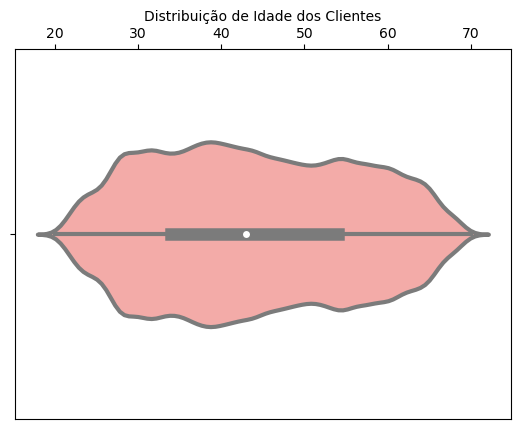

count   215257.00
mean        44.04
std         12.12
min         20.00
25%         34.00
50%         43.00
75%         54.00
max         70.00
Name: DAYS_BIRTH, dtype: float64

In [11]:
fig = sns.violinplot(
    data = abt,
    x = 'DAYS_BIRTH',
    orient='h',
    width= 0.5,
    linewidth= 3,
    color= sns.color_palette('pastel')[3]
)

fig.set_xlabel('Distribuição de Idade dos Clientes')

ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.show()

display(abt['DAYS_BIRTH'].describe())

``!`` Quando olhamos para o gênero, nossa base é composta majoritariamente por mulheres (65%).

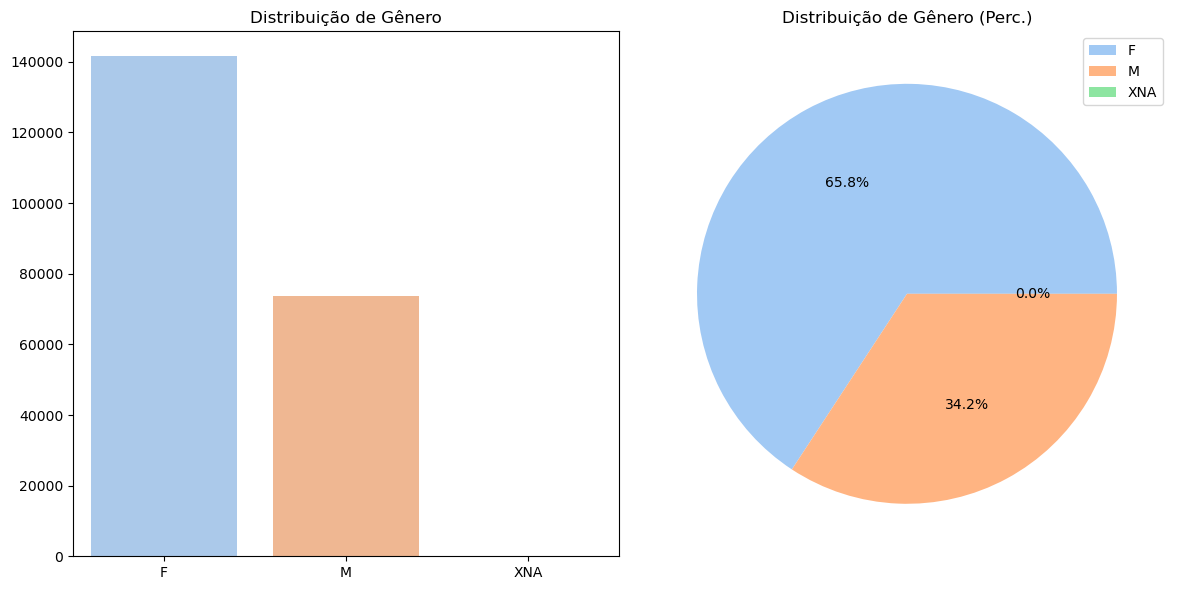

In [12]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)  # (linhas, colunas, índice)
sns.barplot(
    data=abt,
    x=abt['CODE_GENDER'].value_counts().index.tolist(),
    y=abt['CODE_GENDER'].value_counts().values.tolist(),
    palette=sns.color_palette('pastel')
)
plt.title('Distribuição de Gênero')

# Gráfico de pizza
plt.subplot(1, 2, 2)  # (linhas, colunas, índice)
gender_counts = abt['CODE_GENDER'].value_counts()
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), labels=None)
plt.legend(labels=gender_counts.index, loc="upper right")
plt.ylabel('')
plt.title('Distribuição de Gênero (Perc.)')

plt.tight_layout() 

plt.show()

`>` Quando olhamos pra quantidade de filhos, 90% dos nossos clientes tem até 3 filhos, sendo a maior concentração (70%) entre nenhum e apenas 1 filho.

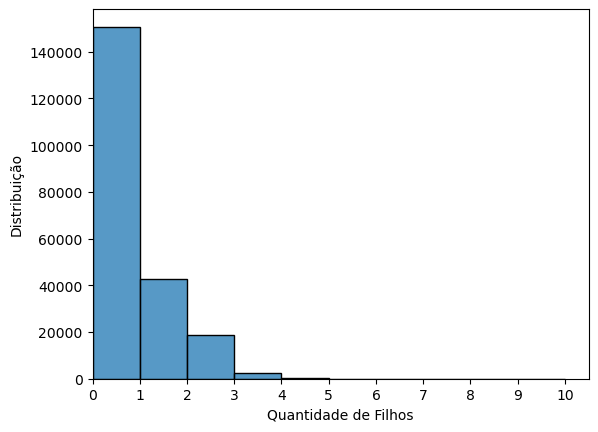

In [13]:
# Ordenando os valores da coluna CNT_CHILDREN
abt_sorted = abt['CNT_CHILDREN'].sort_values()

# Calculando os intervalos para o início de cada barra
dados = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Plot do histograma com bins alinhadas aos valores dos dados
sns.histplot(data= abt['CNT_CHILDREN'], bins=range(min(dados), max(dados) + 1, 1))

plt.xlim(left= 0)

plt.xticks(range(0, 11))

plt.xlabel('Quantidade de Filhos')

plt.ylabel("Distribuição")

plt.show()

`>` Apenas 1/3 dos nossos clientes possui carro, 70% possuem casa ou apartamento próprio.

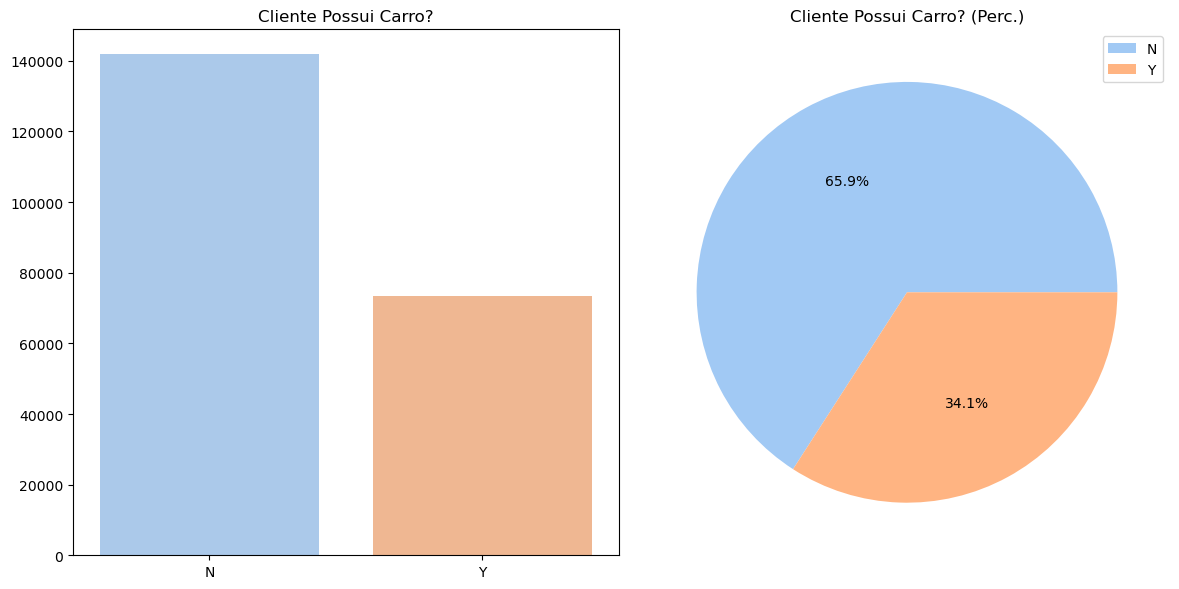

In [14]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)
sns.barplot(
    data=abt,
    x=abt['FLAG_OWN_CAR'].value_counts().index.tolist(),
    y=abt['FLAG_OWN_CAR'].value_counts().values.tolist(),
    palette=sns.color_palette('pastel')
)
plt.title('Cliente Possui Carro?')

# Gráfico de pizza
plt.subplot(1, 2, 2) 
car_counts = abt['FLAG_OWN_CAR'].value_counts()
car_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), labels=None)
plt.legend(labels=car_counts.index, loc="upper right")
plt.ylabel('')
plt.title('Cliente Possui Carro? (Perc.)')

plt.tight_layout()  

plt.show()

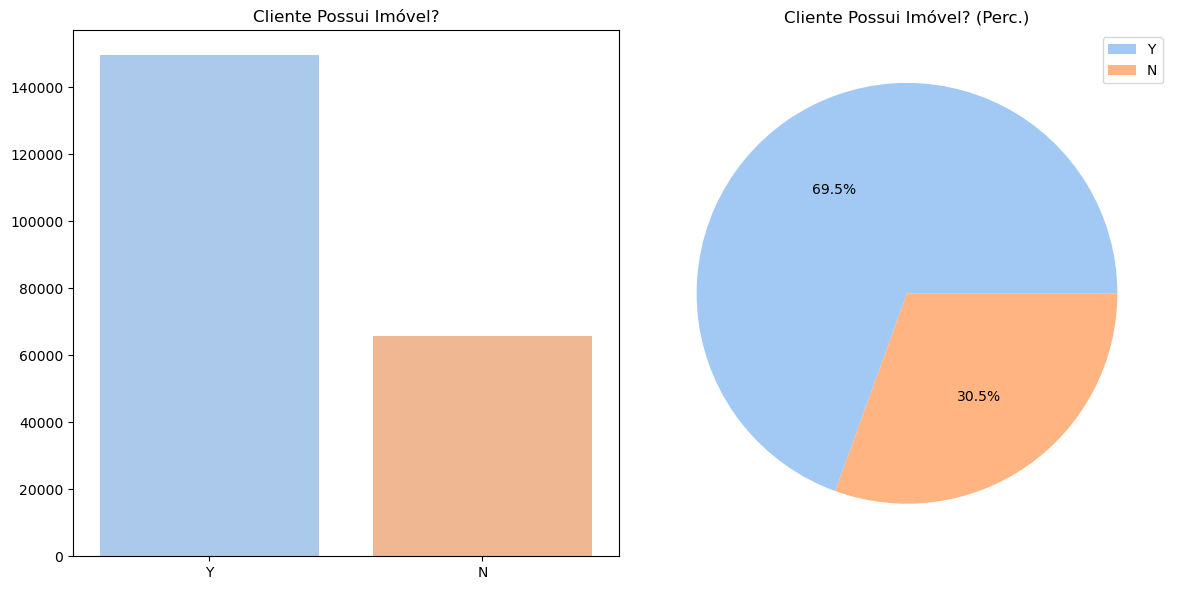

In [15]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)
sns.barplot(
    data=abt,
    x=abt['FLAG_OWN_REALTY'].value_counts().index.tolist(),
    y=abt['FLAG_OWN_REALTY'].value_counts().values.tolist(),
    palette=sns.color_palette('pastel')
)
plt.title('Cliente Possui Imóvel?')

# Gráfico de pizza
plt.subplot(1, 2, 2)
realty_counts = abt['FLAG_OWN_REALTY'].value_counts()
realty_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), labels=None)
plt.legend(labels=realty_counts.index, loc="upper right")
plt.ylabel('')
plt.title('Cliente Possui Imóvel? (Perc.)')

plt.tight_layout()

plt.show()

`!` 90% dos clientes utilizam empréstimos financeiros, enquanto apenas 10% aproximadamente possuem parcelas de cartão de crédito.

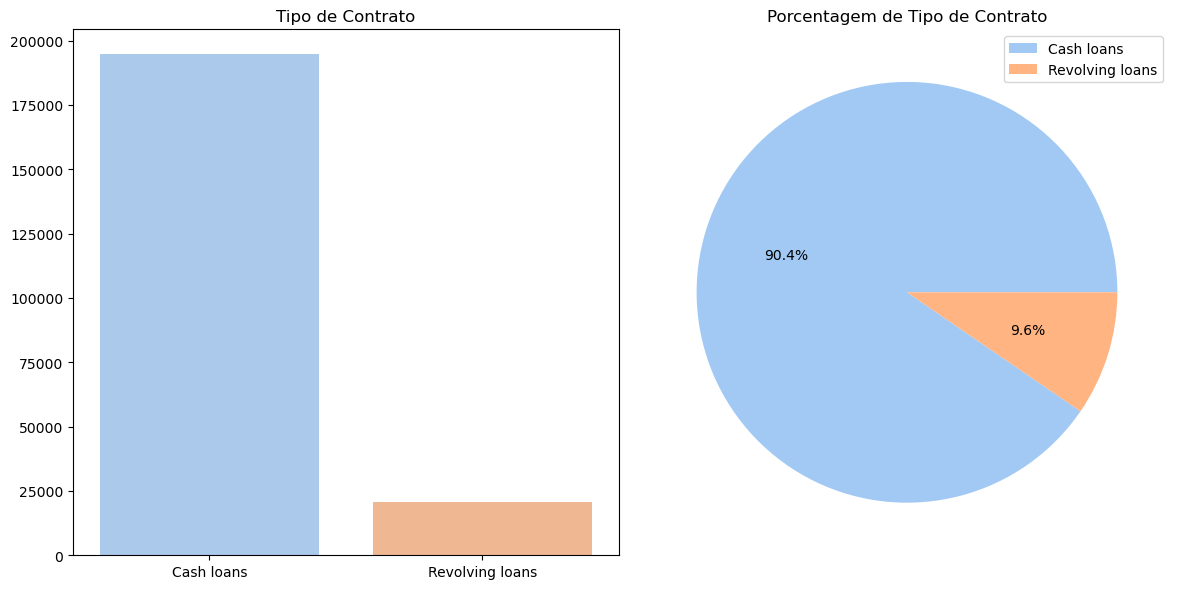

0.054384772263766146

0.08369335723789317

In [16]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)
sns.barplot(
    data=abt,
    x=abt['NAME_CONTRACT_TYPE'].value_counts().index.tolist(),
    y=abt['NAME_CONTRACT_TYPE'].value_counts().values.tolist(),
    palette=sns.color_palette('pastel')
)
plt.title('Tipo de Contrato')

# Gráfico de pizza
plt.subplot(1, 2, 2)
contract_counts = abt['NAME_CONTRACT_TYPE'].value_counts()
contract_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), labels=None)
plt.legend(labels=contract_counts.index, loc="upper right")
plt.ylabel('')
plt.title('Porcentagem de Tipo de Contrato')

plt.tight_layout()

plt.show()

display(abt.loc[abt['NAME_CONTRACT_TYPE'] == 'Revolving loans', 'TARGET'].mean())
display(abt.loc[abt['NAME_CONTRACT_TYPE'] == 'Cash loans', 'TARGET'].mean())

# Analise Multivariada

Como o objetivo principal deste projeto é prever inadimplência, é fundamental entender como as features estão distribuídas em relação a taxa de evento (inadimplência).

Uma abordagem interessante neste momento é plotar todas as features em relação ao target e identificar quais delas possuem uma região específica (no caso das features **numéricas**) ou um domínio específico (no caso das features **categóricas**) que apresenta uma taxa de evento desbalanceada. Isso nos permite distinguir clientes inadimplentes dos adimplentes com maior precisão.

## Numéricas

Para as features numéricas o KDE Plot é suficiente para observarmos algumas features relevantes para o modelo.

A curva em <font color = 'red'>vermelho</font> representa a densidade dos clientes inadimplentes, enquanto a curva <font color = 'green'>verde</font> represente a densidade dos clientes adimplentes.

Observe o comportamento da feature `YEARS BUILD AVG` e compare-o com a feature `DAYS BIRTH`.

Enquanto na primeira as duas curvas estão praticamente sobrepostas conforme o valor da feature cresce, a segunda apresenta um desbalanceamento em uma faixa específica de valores. Isso nos revela dá recorte para investigar, onde há possibilidade de extração de mais insights. Por outro lado, também pode nos indicar que esta feature é uma boa preditora do nosso target[1].

Outras features que nos chamam atenção são `EXT SOURCE 1`, `EXT SOURCE 2` e `EXT SOURCE 3`. Essas features são scores de crédito provenientes de 3 bureaus de crédito distintos. Note como elas possuem alta capacidade de segmentar o target.

[1] A feature `idade` vai de encontro com as listadas como potênciais para desenvolvimento de um modelo de credit scoring por **Abraham Laredo Sicsú**, em sua obra *Credit Scoring: Desenvolvimento - Implantação - Acompanhamento*.

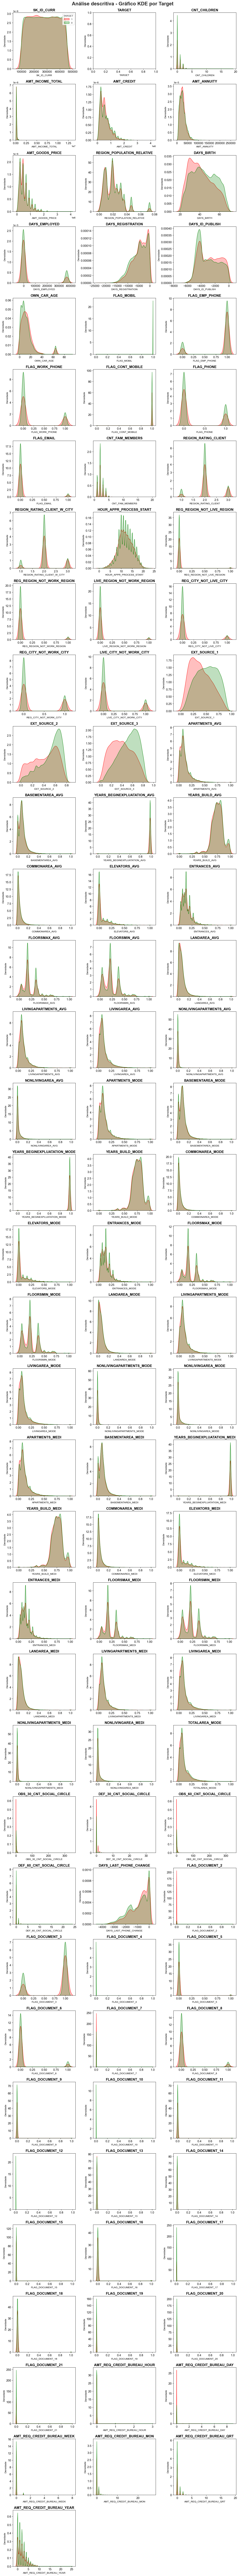

In [17]:
kdeplots_var_num_target(dataframe= abt, target_column= 'TARGET')

## Categóricas

Aqui foi aplicado o mesmo conceito, porém para as features categóricas.

Não conseguimos observar nenhuma feature com desbalanceamento do target em um de seus domínios.

O mais próximo que podemos observar é na feature "CODE GENDER" (Gênero), onde os clientes de label "M" (Masculino) apresentam uma taxa de evento ligeiramente superior.

Aqui, porém, precisamos nos atentar ao próprio balanceamento dos domínios. Como vimos anteriormente na seção de análise univariada, a quantidade de mulheres é quase duas vezes maior que a quantidade de homens.

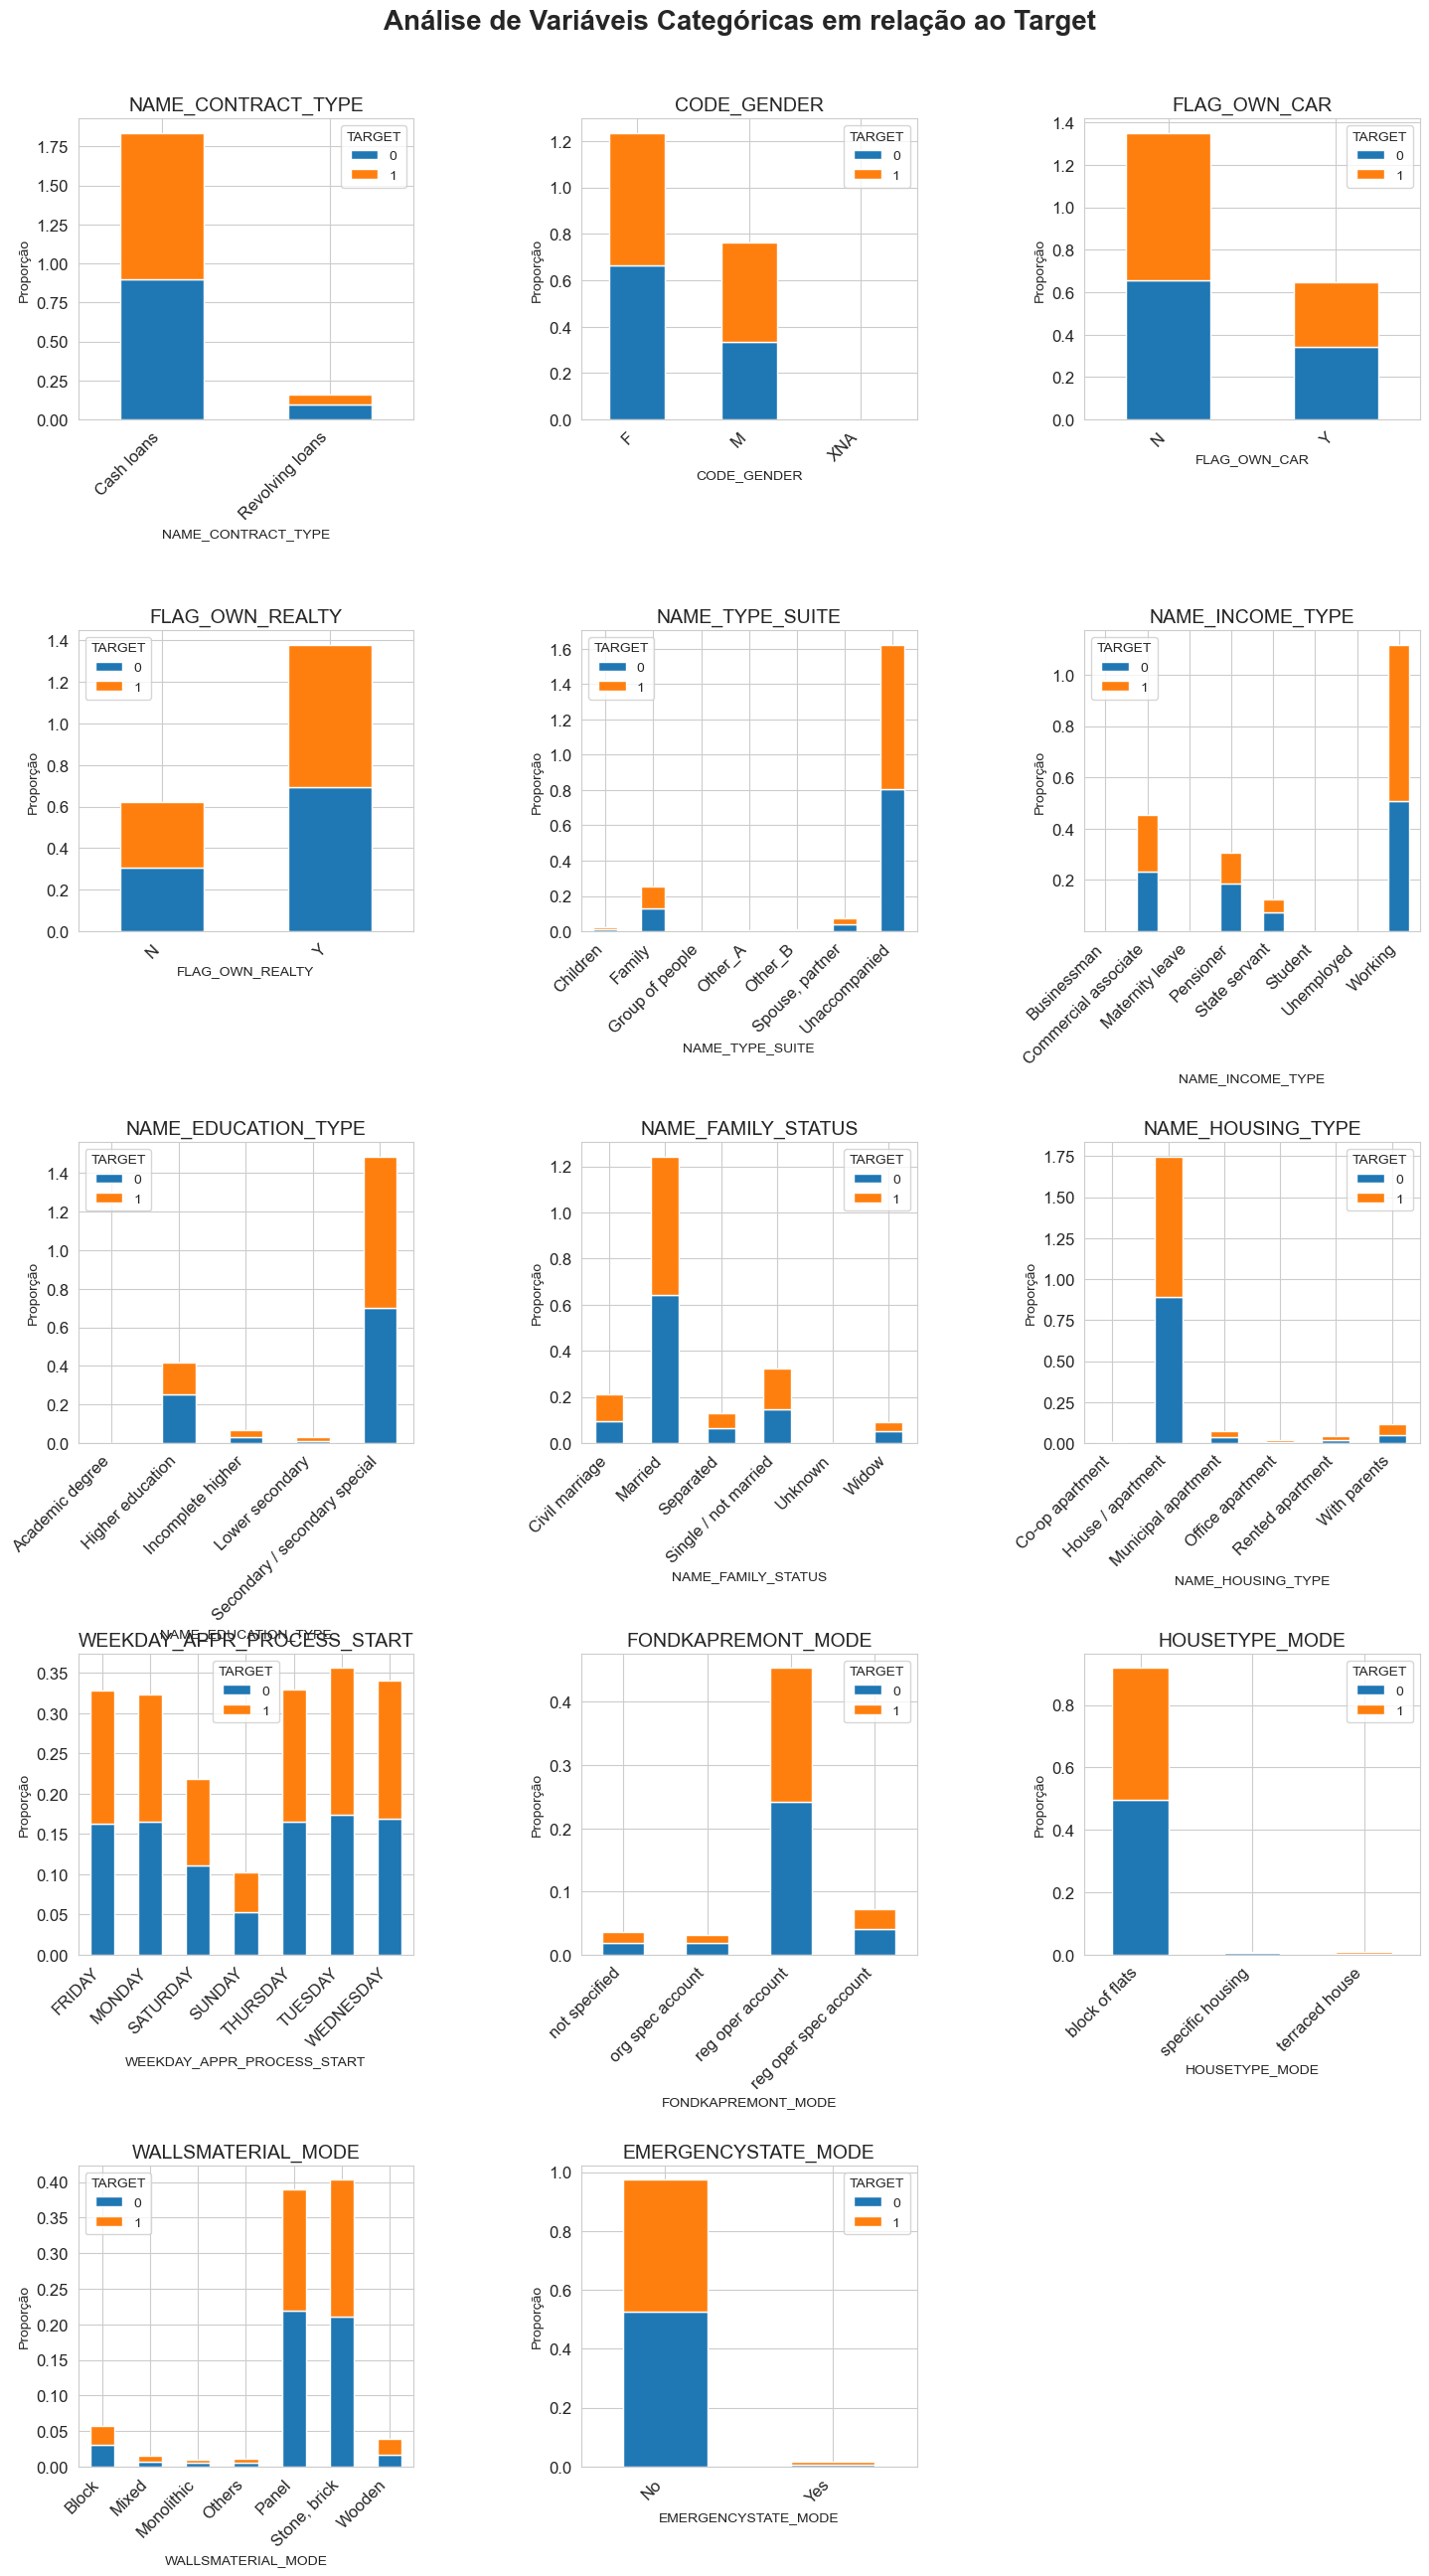

In [18]:
plot_cat_vs_target_cutoff(dataframe= abt, target_column= "TARGET", cutoff=10)

Podemos comprovar nossa análise anterior aplicando o `information value`.

Definindo-o brevemente, o Information Value nos indica o poder preditivo de uma feature em relação a um target, comparando a distribuição da taxa de evento e taxa de não evento para os valores daquela feature.

A aplicação é mais fácil para features categóricas, uma vez que não há necessidade de criar faixas de intervalos, como nas features numéricas.


O information value é calculado da seguinte forma:


$$IV = \sum(p_{evento} \times p_{não-evento}) \times WoE$$

Onde, no nosso caso atual:

$p_{evento}$: Proporção de "1"

$p_{não-evento}$: Proporção de "0"

$WoE = ln(\frac{p_{evento}}{p_{não-evento}})$ (Weight of Evidence)


Aqui estamos interessados em features com IV entre 0.1 e 0.5, que possuem poder preditivo moderado/forte.

IVs muito altos podem indicar features propensas a causar overfitting no modelo.

In [19]:
iv_values = {}
for feature in abt.select_dtypes(include='object').columns:
    iv = calculate_iv(abt, feature, 'TARGET')
    iv_values[feature] = iv

iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'IV'])
iv_df['Categoria_IV'] = pd.cut(iv_df['IV'], bins=[-np.inf, 0.02, 0.1, 0.3, 0.5, np.inf],
                              labels=['not useful for prediction', 'weak predictor', 
                                      'moderate predictor', 'strong predictor', 'suspicious predictor'])

display(iv_df)

,Feature,IV,Categoria_IV
0,NAME_CONTRACT_TYPE,0.02,not useful for prediction
1,CODE_GENDER,inf,suspicious predictor
2,FLAG_OWN_CAR,0.01,not useful for prediction
3,FLAG_OWN_REALTY,0.00,not useful for prediction
4,NAME_TYPE_SUITE,0.00,not useful for prediction
5,NAME_INCOME_TYPE,inf,suspicious predictor
6,NAME_EDUCATION_TYPE,0.05,weak predictor
7,NAME_FAMILY_STATUS,inf,suspicious predictor
8,NAME_HOUSING_TYPE,0.01,not useful for prediction
9,OCCUPATION_TYPE,0.09,weak predictor


Comprovando nossas observações anteriormente, nenhuma feature categórica se mostra capaz de prever bem o nosso target.

# Resumo dos Clientes

Nossa base conta com informações de `215.257` clientes, majoritariamente entre ``34 e 54 anos`` (**alta concentração** entre 30 e 40 anos).

Olhando para o gênero, nosso público é composto em sua maioria por **mulheres** (``65%``).

Em questões de bens, temos um público que em sua maioria (70%) possui casa/apartamento próprio, e apenas 34% possui carro.

Apenas 10% do nosso público utiliza nosso cartão de crédito, enquanto o restante utiliza empréstimos bancários.

A taxa de inadimplência é de 8% olhando o público no geral, 5.4% para os usuários de cartão de crédito e 8.36% para os empréstimos financeiros.